## Introduction
Japan is a island country lying between latitudes 24° and 46°N, and longitudes 122° and 146°E. Japan is substantially prone to earthquakes, tsunami and volcanoes due to its location along the Pacific Ring of Fire. In order to reduce loss suffered from earthquakes, Japan has a long history of recording and studying earthquake. Now we will use these earthquake data to do some preliminary manipulation and visualization.

Personally I like this presentation of plotting life expectancy against income for every country since 1810. Hans shows how the world we live in is radically different from the world most of us imagine vividly. We will try whether we can use similar method to visulize the earthquake data fom Japan Meteorological Agency.

[![IMAGE ALT TEXT HERE](http://img.youtube.com/vi/jbkSRLYSojo/0.jpg)](https://www.youtube.com/watch?v=jbkSRLYSojo)

### Tutorial content

In this tutorial, we will show how to use Matplotlib in data visualization to illustrate time series data of earthquake in Japan.

We'll be using data collected from Japan Meteorological Agency: http://www.data.jma.go.jp/svd/eqev/data/bulletin/hypo.html

We will cover the following topics in this tutorial:
- [Installing and loading the libraries](#Installing-and-loading-the-libraries)
- [Obtaining raw data](#Obtaining-raw-data)
- [Preparing data](#Preparing-data)
- [Showing Japanese map](#Showing-Japanese-map)
- [Plotting data on map](#Plotting-data-on-map)
- [Time series data visualization](#Time-series-data-visualization)

## Installing and loading the libraries

Before getting started, you'll need to install the various libraries that we will use. You can install Matplotlib Basemap Toolkit using the command below:

    $ conda install -c anaconda basemap=1.0.7
You can also follow the install instruction: http://matplotlib.org/basemap/users/installing.html

And you also need to record animation, as you'll see earthquake time series, so you need to install ffmpeg which is used by Jupyter notebook to record animation. You can follow the install instruction: https://www.ffmpeg.org/download.html

After you run all the installs, make sure the following commands work for you.

In [1]:
import requests
from bs4 import BeautifulSoup
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap
from IPython.display import HTML
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

## Obtaining raw data

Now that we've installed and loaded the libraries. Then we use library "requests" to download the zipped file and use library "zipfile" to decompress and obtain the raw file. In this tutorial, we will load earthquake data from 2011 to 2015.

In [2]:
def download_file(src):
    file_name = src[src.rfind('/')+1:]
    r = requests.get(src, stream=True)
    with open(file_name, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

def get_raw_data(src='http://www.data.jma.go.jp/svd/eqev/data/bulletin/hypo.html', from_year=1983, to_year=2015):
    prefix = src[:src.rfind('/')+1]
    response = requests.get(src)
    root = BeautifulSoup(response.content, 'html.parser')
    for link in root.findAll('a'):
        target = link.get('href').strip()
        rindex = target.rfind('/')
        if target[-3:] == 'zip' and from_year<= int(target[rindex+2: rindex+6]) <= to_year:
            download_file(prefix + target)
    print "Download complete!"
    
def decompress_files(directory='data', extension='.zip'):
    cur_d = os.getcwd()
    target_d = cur_d + '/' + directory
    # loop through items in dir
    for item in os.listdir(cur_d):
        # check for ".zip" extension
        if item.endswith(extension):
            file_name = os.path.abspath(item)  # get full path of files
            zip_ref = zipfile.ZipFile(file_name)  # create zipfile object
            zip_ref.extractall(target_d)  # extract file to dir
            zip_ref.close()  # close file
            os.remove(file_name)  # delete zipped file
    print "Decompress complete!"
    

get_raw_data('http://www.data.jma.go.jp/svd/eqev/data/bulletin/hypo.html', 2011, 2015)
decompress_files()

Download complete!
Decompress complete!


## Preparing data

After we get the data file from Internet, we then load the data from files. You can open the files in "data" sub-folder and have a look at the raw data. The data is actually stored in fixed-width format. You can learn the format of records from: http://www.data.jma.go.jp/svd/eqev/data/bulletin/data/format/hypfmt_j.html
Here is some important data that we will use in our tutorial.

| Index | type |  content                              |
|-------|------|---------------------------------------|
| 02-05 | I4   | year of original time of earthquake   |
| 06-07 | I2   | month of original time of earthquake  |
| 08-09 | I2   | day of original time of earthquake    |
| 10-11 | I2   | hour of original time of earthquake   |
| 12-13 | I2   | minute of original time of earthquake |
| 14-17 | F4.2 | second of original time of earthquake |
| 22-24 | I3   | latitude (degrees)                    |
| 25-28 | F4.2 | latitude (minutes)                    |
| 33-36 | I3   | longitude (degrees)                   |
| 37-40 | F4.2 | longitude (minutes)                   |
| 53-54 | F2.1 | magnitude1                            |
| 56-57 | F2.1 | magnitude2                            |
| 62    | A1   | maximum intensity                     |
| 63    | A1   | damage scale                          |


In [3]:
def load_data(directory):
    if directory is None:
        directory = os.getcwd() + '/data'
    
    # specification
    cols = [(1,5), (5,7), (7,9), (9,11), (11,13), (13,17), (21,24),
            (24,28), (32,36), (36,40), (52,54), (55,57), (61,62), (62,63)]
    col_names = ['year', 'month', 'day', 'hour', 'minute', 'second', 'latitude_degree', 'latitude_minute',
                 'longtitude_degree', 'longtitude_minute', 'magnitude1', 'magnitude2', 'intensity', 'damage_scale']
    
    result = pd.DataFrame()
    # loop through items in dir
    for item in os.listdir(directory):
        if item[0] != '.':
            file_name = directory + '/' + item  # get full path of files
            pdf = pd.read_fwf(file_name, colspecs=cols, names=col_names)
            result = result.append(pdf)
    
    return result

pdf = load_data(None)
print pdf.dtypes
print pdf.head()

year                   int64
month                  int64
day                    int64
hour                   int64
minute                 int64
second                 int64
latitude_degree       object
latitude_minute        int64
longtitude_degree     object
longtitude_minute      int64
magnitude1            object
magnitude2           float64
intensity             object
damage_scale         float64
dtype: object
   year  month  day  hour  minute  second latitude_degree  latitude_minute  \
0  2011      1    1     0       1    2561              41             1791   
1  2011      1    1     0       4    5665              35             2554   
2  2011      1    1     0      11    5880              35             5734   
3  2011      1    1     0      12    5696              38             4189   
4  2011      1    1     0      18     285              28              156   

  longtitude_degree  longtitude_minute magnitude1  magnitude2 intensity  \
0               142               48

We also need to deal with the data. For example, in magnitude field, there are also some letters other than float number, we need to transfer them into corresponding float numbers. We also combine several time related columns into datetime when the earthquake happened. And then we also change the type of latitude and longtitude into float. Finally we drop any rows that has empty items.

In [4]:
def trans_magnitude(m):
    '''
       -0.1: -1   -0.9: -9   -1.0: A0
       -1.9: A9   -2.0: B0   -3.0: C0
    '''
    if m == '-1':
        return -0.1
    elif m == '-9':
        return -0.9
    elif m =='A0':
        return -1.0
    elif m == 'A9':
        return -1.9
    elif m == 'B0':
        return -2.0
    elif m == 'C0':
        return -3.0
    elif str(m).isdigit():
        return float(str(m)) / 10.0
    elif str(m)[0] == '-' and str(m)[1].isdigit():
        return float(str(m)) / 10.0
    else:
        return float('NaN')

def generate_plotting_data(pdf):
    seism = pd.DataFrame()
    seism['tms'] = pd.to_datetime(pdf.year*10000000000 + pdf.month*100000000 + pdf.day*1000000
                                  + pdf.hour*10000 + pdf.minute*100 + pdf.second//100,
                                  format='%Y%m%d%H%M%S')
    seism['latitude'] = pdf.latitude_degree.apply(pd.to_numeric, errors='coerce')\
                      + pdf.latitude_minute / 100 / 60
    seism['longtitude'] = pdf.longtitude_degree.apply(pd.to_numeric, errors='coerce')\
                        + pdf.longtitude_minute / 100 / 60
    seism['magnitude'] = pdf.magnitude1.fillna(pdf.magnitude2).apply(trans_magnitude)
    seism = seism.dropna()
    return seism

seism_data = generate_plotting_data(pdf)
print seism_data.dtypes
print seism_data.head()

tms           datetime64[ns]
latitude             float64
longtitude           float64
magnitude            float64
dtype: object
                  tms   latitude  longtitude  magnitude
0 2011-01-01 00:01:25  41.298500  142.802167        2.4
1 2011-01-01 00:04:56  35.425667  139.922000        0.9
2 2011-01-01 00:11:58  35.955667  140.155833        0.9
3 2011-01-01 00:12:56  38.698167  142.259167        1.8
4 2011-01-01 00:18:02  28.026000  130.144833        1.8


## Showing Japanese map

In order to represent the curved surface of the earth on a two-dimensional map, a map projection is needed. There are many map projection method, each of which has its own advantage and disadvantage. In the tutorial we plot Japanese map in mercator projection which is a cylindrical, conformal projection. But this method has very large distortion at high latitudes and cannot fully reach the polar regions.

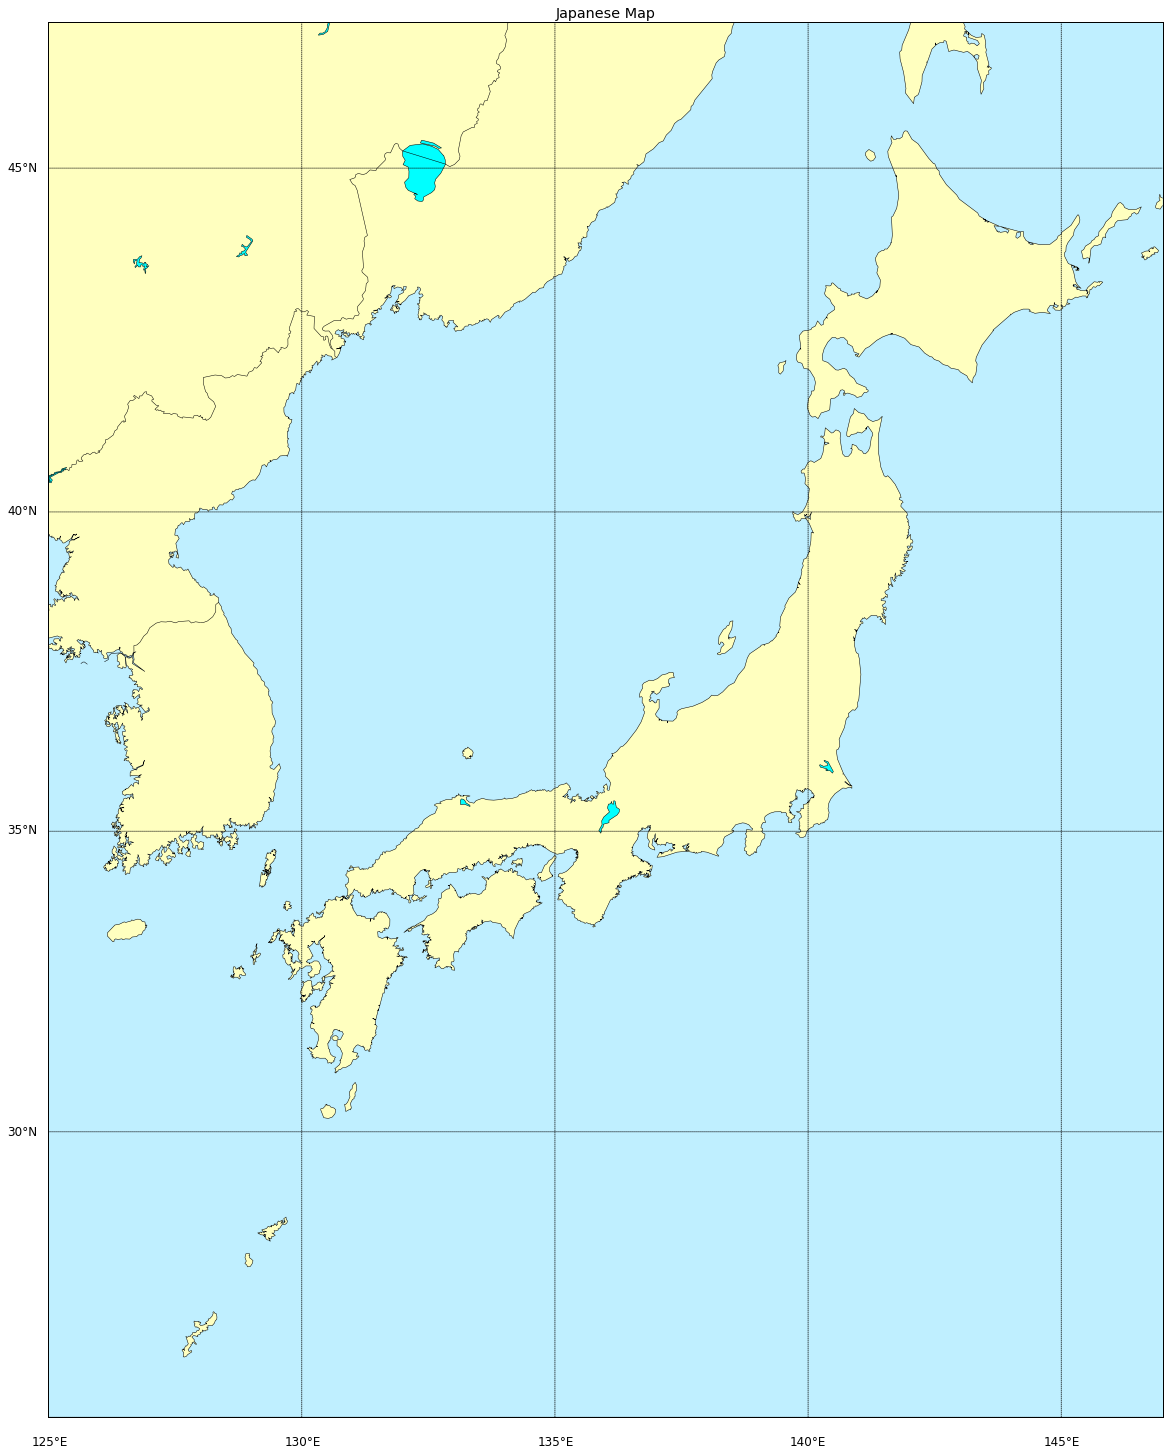

In [5]:
fig = plt.figure(figsize=(25,25))
m = Basemap(projection='merc',llcrnrlat=25.0,urcrnrlat=47.0,
            llcrnrlon=125.0,urcrnrlon=147.0,resolution='i')
m.drawcoastlines(linewidth=0.5, color='#000000')
m.fillcontinents(color='#ffffbf',lake_color='#00ffff')
m.drawstates(linewidth=0.5, color='#000000')
m.drawcountries(linewidth=0.5, color='#000000')
m.drawmapboundary(fill_color='#bfefff')
m.drawparallels(np.arange(25,50,5), labels = [1,0,0,0], fontsize=12)
m.drawmeridians(np.arange(125,150,5), labels = [0,0,0,1], fontsize=12)
plt.title("Japanese Map")
plt.show()

## Plotting data on map

When we look through the earthquake data, we can find many earthquakes with small magnitude which can be regarded as aftershocks or be ignored. And we can also ignore the earthquakes which are far from Japanese mainland. So we select those earthquakes whose locations are near Japan and magnitudes are larger than 6.0. Then we plot earthquake data with two major Japanese cities onto Japanese map. On the map, we use latitude and longtitude to represent earthquakes' location, use area of the points to represent earthquakes' magnitude.

In [6]:
plot_data = seism_data[(seism_data.magnitude>=6.0)&(25.0<=seism_data.latitude)&(seism_data.latitude<=47.0)&(125.0<=seism_data.longtitude)&(seism_data.longtitude<=147.0)]
print plot_data

                       tms   latitude  longtitude  magnitude
4042   2011-01-13 06:32:54  27.076167  140.174000        6.3
23459  2011-03-09 11:45:12  38.328500  143.279833        7.3
23464  2011-03-09 11:57:10  38.322333  143.397333        6.2
23465  2011-03-09 11:58:11  38.298833  143.155167        6.0
23523  2011-03-09 13:36:59  38.606500  143.248833        6.1
23867  2011-03-10 03:16:14  38.271167  142.878833        6.4
23873  2011-03-10 03:44:35  38.479500  143.432833        6.3
23934  2011-03-10 06:22:11  38.132833  143.218667        6.3
23936  2011-03-10 06:23:59  38.172167  143.044833        6.8
24563  2011-03-11 14:46:18  38.103500  142.861000        9.0
24577  2011-03-11 14:51:20  37.310667  142.237500        6.8
24625  2011-03-11 14:54:31  37.508000  141.353167        6.1
24646  2011-03-11 14:55:53  36.492500  141.772833        6.0
24668  2011-03-11 14:58:05  37.689000  141.933833        6.6
24708  2011-03-11 15:03:58  36.329833  141.962167        6.0
24717  2011-03-11 15:06:

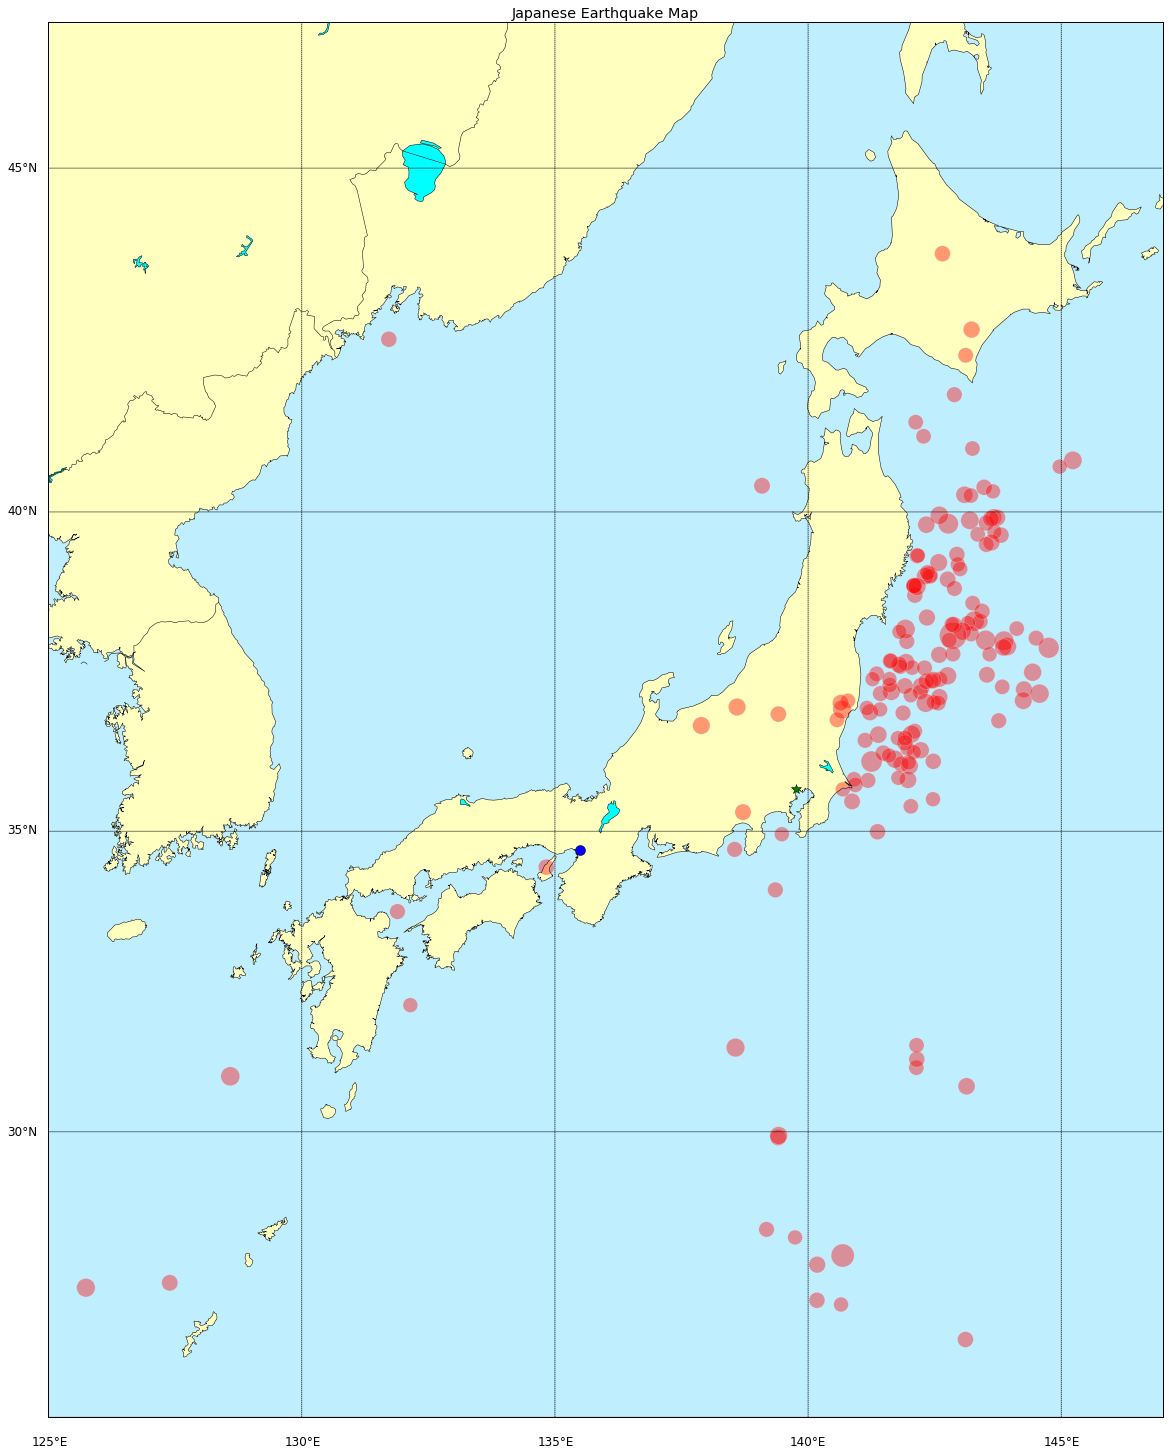

In [7]:
fig = plt.figure(figsize=(25,25))
m = Basemap(projection='merc',llcrnrlat=25.0,urcrnrlat=47.0,
            llcrnrlon=125.0,urcrnrlon=147.0,resolution='i')
m.drawcoastlines(linewidth=0.5, color='#000000')
m.fillcontinents(color='#ffffbf',lake_color='#00ffff',zorder=0)
m.drawstates(linewidth=0.5, color='#000000')
m.drawcountries(linewidth=0.5, color='#000000')
m.drawmapboundary(fill_color='#bfefff')
m.drawparallels(np.arange(25,50,5), labels = [1,0,0,0], fontsize=12)
m.drawmeridians(np.arange(125,150,5), labels = [0,0,0,1], fontsize=12)


x, y = m(np.array(plot_data.longtitude), np.array(plot_data.latitude))
m.scatter(x, y, np.array(plot_data.magnitude**3), marker='o', c='r', alpha=0.4)
tokyo_lat = 35.681394
tokyo_lon = 139.766060
osaka_lat = 34.701921
osaka_lon = 135.494985
# 東京駅
t_x, t_y = m( tokyo_lon, tokyo_lat)
m.plot( t_x, t_y, 'g*', ms = 10 )
# 大阪駅
o_x, o_y = m(osaka_lon, osaka_lat)
m.plot( o_x, o_y, 'bo', ms = 10 )

plt.title("Japanese Earthquake Map")
plt.show()

## Time series data visualization

Finally we use animation to visualize time series of earthquake data. In order to better show earthquake data in chronological sequence, we add column color and frame. We use a four float number tuple to store colors with opaqueness and use days of timedelta between the time when earthquake happened and the beginning of 2011 which is the start year of our earthquake data, to determine when we should show the earthquake data on the map.
As my tutorial is dynamic, it may not be reviewed in static web page, I have uploaded a recorded video to youtube. In case you can not watch the vedio, you can review the animation here: https://drive.google.com/open?id=0B5YoUHayu_CreFBST3prekNJX2s

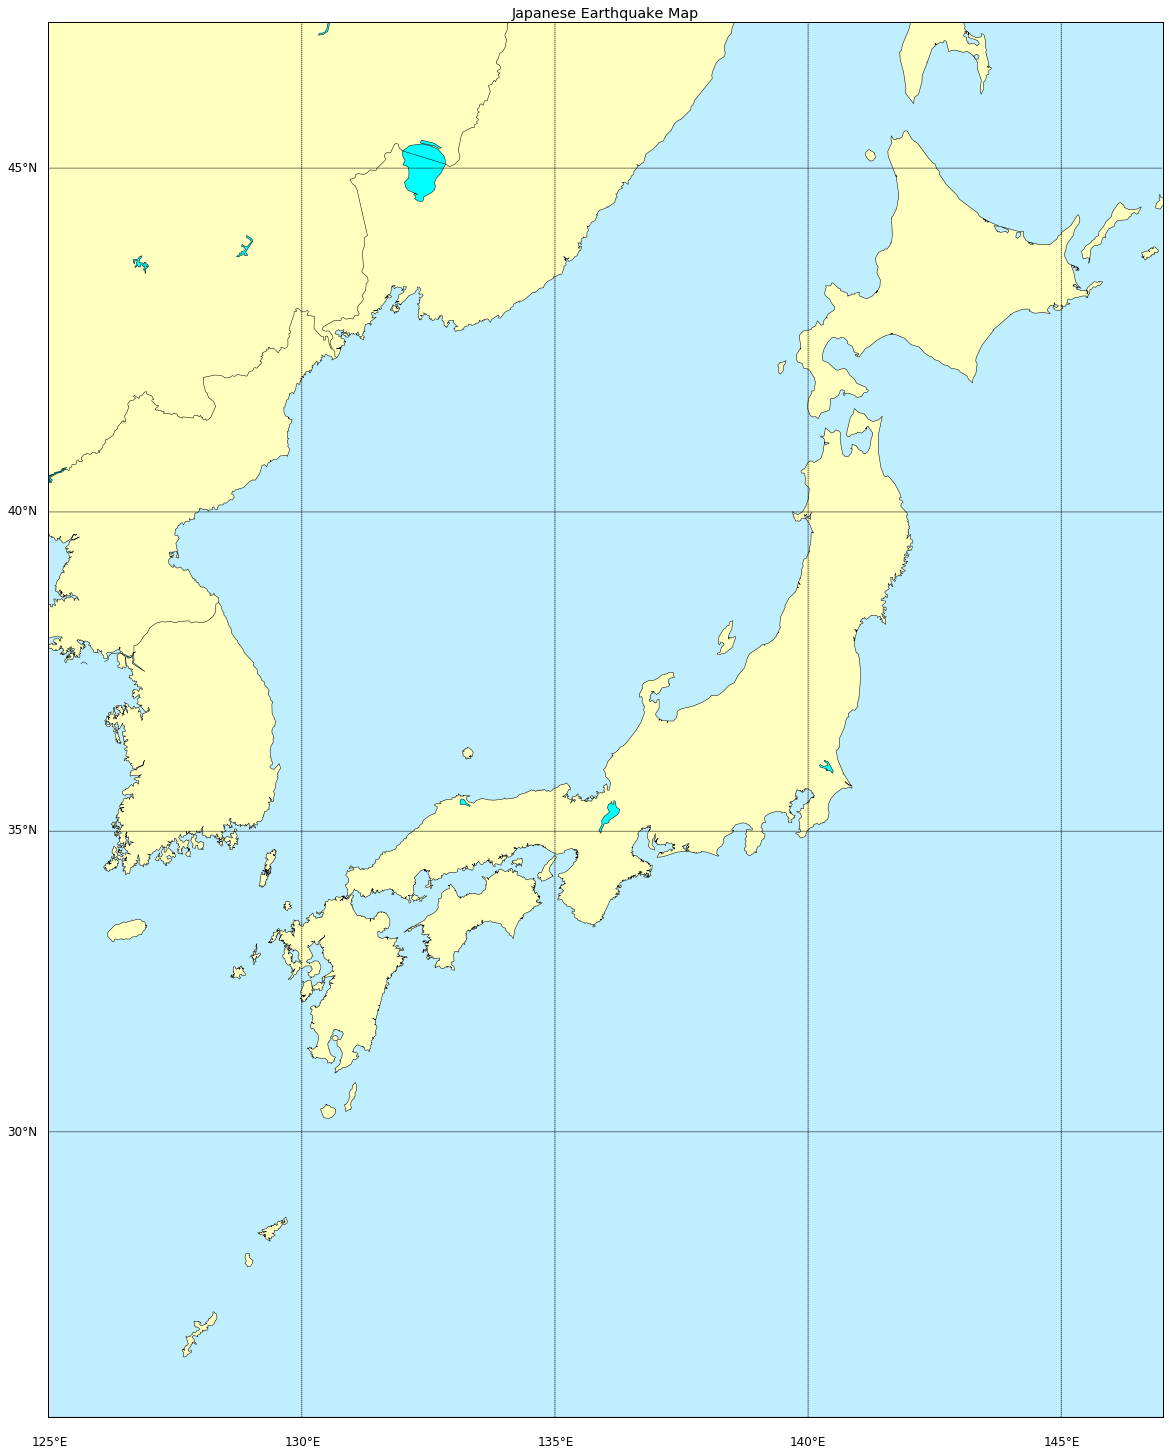

In [10]:
fig = plt.figure(figsize=(25,25))
plt.title("Japanese Earthquake Map")
m = Basemap(projection='merc',llcrnrlat=25.0,urcrnrlat=47.0,
            llcrnrlon=125.0,urcrnrlon=147.0,resolution='i')
m.drawcoastlines(linewidth=0.5, color='#000000')
m.fillcontinents(color='#ffffbf',lake_color='#00ffff',zorder=0)
m.drawstates(linewidth=0.5, color='#000000')
m.drawcountries(linewidth=0.5, color='#000000')
m.drawmapboundary(fill_color='#bfefff')
m.drawparallels(np.arange(25,50,5), labels = [1,0,0,0], fontsize=12)
m.drawmeridians(np.arange(125,150,5), labels = [0,0,0,1], fontsize=12)

n_plot_data = len(plot_data)
plot_data = plot_data.assign(color=[(1.0, 0, 0, 0.0)]*n_plot_data)
plot_data['frame'] = (plot_data.tms - pd.Timestamp('2011-01-01 00:00:00')).apply(lambda x: int(x.days))
max_frame = plot_data.frame.max()

x, y = m(np.array(plot_data.longtitude), np.array(plot_data.latitude))
scat = m.scatter(x, y, np.array(plot_data.magnitude**3), marker='o', facecolors=plot_data.color, edgecolors='none')
index = [0]

def fade(color):
    return (color[0], color[1], color[2], max(color[3] - 0.2, 0))

def update(frame_number, i):
    while i[0] < n_plot_data and plot_data.loc[plot_data.index[i[0]], 'frame'] == frame_number:
        c = plot_data.loc[plot_data.index[i[0]], 'color']
        plot_data.set_value(plot_data.index[i[0]], 'color', (c[0], c[1], c[2], 1.2))
        i[0] += 1

    plot_data.color = plot_data.color.apply(fade)
    scat.set_facecolors(plot_data.color)

anim = FuncAnimation(fig, update, frames=(max_frame+5), fargs=(index,), interval=50)

HTML(anim.to_html5_video())

## Conclusion

1. With the help of animation, we represent datetime, longtitude, latitude, magnitude of earthquake data and we can further use color to represent different earthquake caused by different Trough. In this tutorial, we provide an option to visualize many properties of data at the same time.
2. Since Eastern Japanes Earthquake happened in 2011, we can notice more powerful earthquakes happened around north eastern Japan densely and explosively.
3. Although we can observe earthquake time series dataset directly and intuitively by using matplotlib animation function and we can furthermore smooth the animation by tuning parameters frame and interval, it costs a lot of computational time to generate the 90-second animation. Noticing we only plot 166 earthquake data points in 5 years, it is not suitable to use animation in large data analysis, but we can use this method to test and verify our perception towards data by using small quantity of data chosen from dataset randomly.

## Further work

1. We can also use k-Nearest Neighbors algorithm which is an unsupervised machine learning algorithm to classify the earthquakes happening near Japan and use different color to plot different earthquake data. We can see whether the earthquake data can be divided into three or more groups, each of which is caused by Tokai Trough, Nankai Trough or Tonankai Trough respectively.
2. As we all known, there are also many volcano activities in Japan. We can also plot volcano eruption on the map and see whether there are any visualized relation between volcano eruption and earthquake. Comparing with earthquake, it is easier to monitor volcano activities. So if we can use machine learning algorithms to find any probabilistic relation between volcano activities and earthquake, it can help to forecast earthquake.

## Summary and references
This tutorial highlights the utilization of Matplotlib in data visualization to illustrate time series data of earthquake in Japan. Much more details related are available from the following links.

1. Basemap Matplotlib Toolkit: http://matplotlib.org/basemap/index.html
2. Hans Rosling's 200 Countries, 200 Years, 4 Minutes - The Joy of Stats - BBC Four: https://www.youtube.com/watch?v=jbkSRLYSojo
3. Japan Meteorological Agency: http://www.data.jma.go.jp/svd/eqev/data/bulletin/hypo.html
4. Animation example code: rain.py: http://matplotlib.org/examples/animation/rain.html
5. Embedding Matplotlib Animations in Jupyter Notebooks: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
6. Download ffmpeg: https://www.ffmpeg.org/download.html